# Simple ELO 
In this notebook, I explore the application of a simple ELO calculation to the historical NFL data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 

%matplotlib inline

In [2]:
data_dir = os.path.abspath('../data')
print(f'Loading data from {data_dir}..')

Loading data from /Users/davidriser/repos/nfl-ratings/data..


Let's load the data and apply some simple filters, based on the exploration.  I have decided to exclude matches before 1960, when the league expanded.

In [3]:
data = pd.read_csv(f'{data_dir}/historical_data.csv')
data = data[np.logical_not(
    np.logical_or(data['team1'].isna(), data['team2'].isna())
)]
data = data[data['season'] > 1959]
data['date'] = pd.to_datetime(data['date'])

In [4]:
data.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2
2903,1960-09-09,1960,0,NaN,NE,DEN,1300.000,1300.000,0.592466,0.407534,...,0.566862,0.433138,12.540000,122.760000,1.254000,32.931770,1283.942071,1316.057929,10.0,13.0
2904,1960-09-10,1960,0,NaN,LAC,KC,1300.000,1300.000,0.592466,0.407534,...,0.589531,0.410469,316.140000,153.120000,31.614000,11.872908,1305.532159,1294.467841,21.0,20.0
2905,1960-09-11,1960,0,NaN,OAK,TEN,1300.000,1300.000,0.592466,0.407534,...,0.523584,0.476416,147.180000,238.920000,14.718000,86.530014,1270.748277,1329.251723,22.0,37.0
2906,1960-09-11,1960,0,NaN,NYJ,BUF,1300.000,1300.000,0.592466,0.407534,...,0.534573,0.465427,116.820000,-67.650000,11.682000,36.502993,1329.638852,1270.361148,27.0,3.0
2907,1960-09-16,1960,0,NaN,OAK,KC,1266.146,1294.513,0.552525,0.447475,...,0.556189,0.443811,-96.257257,185.463743,3.620474,29.231991,1237.400627,1327.815491,16.0,34.0


In [5]:
active_teams1 = set(data[data['season'] == 2019]['team1'].unique())
active_teams2 = set(data[data['season'] == 2019]['team2'].unique())
active_teams = active_teams1.union(active_teams2)

In [6]:
print(len(active_teams) == 32)

True


In [7]:
train_data = data[['team1', 'team2', 'score1', 'score2', 'season', 'date']] 

Simple ELO calculation, everyone starts with a rating of 1250 and is given a maximum of 25 points for winning.  I'll be iterating over the rows of the dataframe, typically this is bad practice.  I am waiting to find a better way to do this.

In [8]:
def win_proba(rating1, rating2):
    diff = rating2-rating1
    return 1.0 / (10**(diff/400) + 1)

In [9]:
# Defined to be 0.9
win_proba(401, 1)

0.9090909090909091

In [10]:
def simple_elo(train_data, active_teams, start_rating = 1250, reward = 25):

    ngames = len(train_data)

    # Setup the output fields 
    elo1_pre = np.repeat(start_rating, ngames)
    elo2_pre = np.repeat(start_rating, ngames)
    elo1_post = np.repeat(start_rating, ngames)
    elo2_post = np.repeat(start_rating, ngames)
    elo_prob1 = np.repeat(0.5, ngames)
    elo_prob2 = np.repeat(0.5, ngames)

    current_ratings = { team:start_rating for team in active_teams }

    for index in range(ngames):    

        # Get the current matchup between two teams 
        game = train_data.iloc[index]
        team1, team2 = game['team1'], game['team2']

        # Get thier current ratings from our dictionary 
        rating1, rating2 = current_ratings[team1], current_ratings[team2]    
        elo1_pre[index] = rating1
        elo2_pre[index] = rating2

        # Calculate the win probability for each team 
        prob1 = win_proba(rating1, rating2)
        prob2 = 1.0 - prob1
        elo_prob1[index] = prob1
        elo_prob2[index] = prob2

        # Figure out if the home team won, lost, and drew the game 
        outcome = 0
        if game['score1'] > game['score2']:
            outcome = 1
        elif game['score1'] < game['score2']:
            outcome = -1

        # Update the ELO of each team based on the results 
        if outcome == 1:
            rating1 += reward * prob2
            rating2 -= reward * prob2
        elif outcome == -1:
            rating1 -= reward * prob1
            rating2 += reward * prob1

        # Update the dataframe and current ratings
        current_ratings[team1] = rating1
        current_ratings[team2] = rating2

        elo1_post[index] = rating1
        elo2_post[index] = rating2

    train_data['elo1_pre'] = elo1_pre
    train_data['elo2_pre'] = elo2_pre
    train_data['elo1_post'] = elo1_post
    train_data['elo2_post'] = elo2_post
    train_data['elo_prob1'] = elo_prob1
    train_data['elo_prob2'] = elo_prob2
    
    return train_data, current_ratings 

In [11]:
train_data, current_ratings = simple_elo(train_data, active_teams, 1500, 25)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

In [17]:
def plot_ratings(ratings):
    teams = np.array(list(ratings.keys()))
    scores = np.array(list(ratings.values()))
    idx = np.argsort(scores)
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    ax.barh(teams[idx][:8], scores[idx][:8], edgecolor='k', alpha=0.7, color='orange')
    ax.barh(teams[idx][8:24], scores[idx][8:24], edgecolor='k', alpha=0.7, color='purple')
    ax.barh(teams[idx][24:], scores[idx][24:], edgecolor='k', alpha=0.7, color='red')
    ax.set_title('Simple ELO Ratings')
    ax.set_xlabel('Rating')
    ax.set_xlim([1300, 1950])
    ax.grid(alpha=0.2)

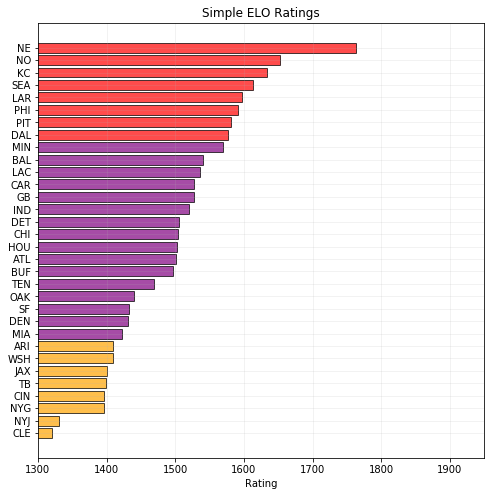

In [18]:
plot_ratings(current_ratings)

# Ratings As a Function of Start Time
How far back do we need to go?  Do the results eventually end up the same?

In [19]:
year_based_results = {}
year_based_results['start_year'] = [] 
year_based_results['result'] = [] 
year_based_results['ratings'] = [] 

for start_year in range(1960, 1990, 5):
    print(f'Calculating results from starting at {start_year}')
    year_based_results['start_year'].append(start_year)
    year_data, ratings = simple_elo(train_data[train_data['season'] >= start_year], 
                                    active_teams, 1500, 25)
    year_based_results['result'].append(year_data)
    year_based_results['ratings'].append(ratings)

Calculating results from starting at 1960
Calculating results from starting at 1965


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Calculating results from starting at 1970
Calculating results from starting at 1975
Calculating results from starting at 1980
Calculating results from starting at 1985


In [20]:
year_based_results['result'][0]

,team1,team2,score1,score2,season,date,elo1_pre,elo2_pre,elo1_post,elo2_post,elo_prob1,elo_prob2
2903,NE,DEN,10.0,13.0,1960,1960-09-09,1500,1500,1487,1512,0.500000,0.500000
2904,LAC,KC,21.0,20.0,1960,1960-09-10,1500,1500,1512,1487,0.500000,0.500000
2905,OAK,TEN,22.0,37.0,1960,1960-09-11,1500,1500,1487,1512,0.500000,0.500000
2906,NYJ,BUF,27.0,3.0,1960,1960-09-11,1500,1500,1512,1487,0.500000,0.500000
2907,OAK,KC,16.0,34.0,1960,1960-09-16,1487,1487,1475,1500,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
16525,CAR,NO,NaN,NaN,2019,2019-12-29,1527,1653,1527,1653,0.326861,0.673139
16526,MIN,CHI,NaN,NaN,2019,2019-12-29,1568,1504,1568,1504,0.592390,0.407610
16527,SEA,SF,NaN,NaN,2019,2019-12-29,1613,1432,1613,1432,0.739224,0.260776
16528,DEN,OAK,NaN,NaN,2019,2019-12-29,1431,1439,1431,1439,0.488009,0.511991


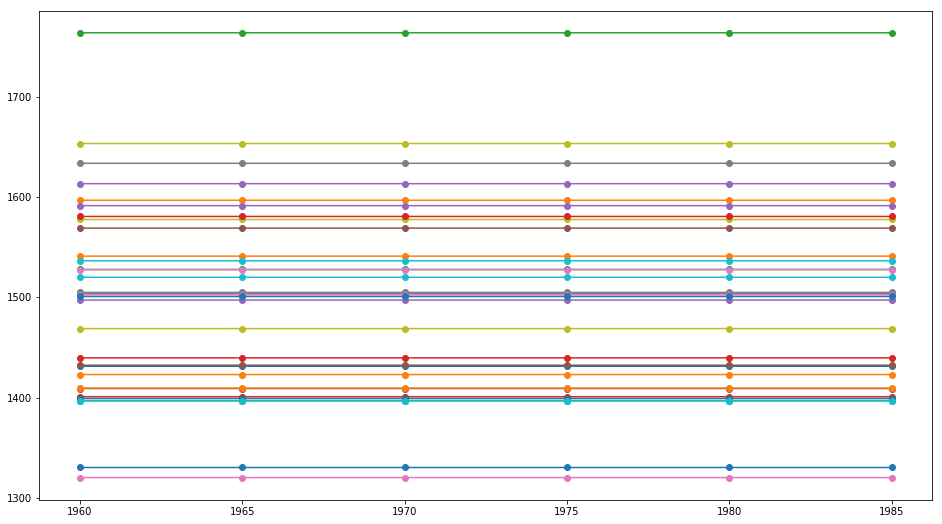

In [21]:
plt.figure(figsize=(16,9))
for team in active_teams:
    plt.plot(year_based_results['start_year'], 
                [r[team] for r in year_based_results['ratings']],
            marker='o')

In [22]:
train_data = data[['team1', 'team2', 'score1', 'score2', 'season', 'date']] 

It looks like things end up right about the same regardless of when we start, this shouldn't hold all the way up to modern times...  Let's try to break it.

In [23]:
year_based_results = {}
year_based_results['start_year'] = [] 
year_based_results['result'] = [] 
year_based_results['ratings'] = [] 

for start_year in range(2010, 2017, 1):
    print(f'Calculating results from starting at {start_year}')
    year_based_results['start_year'].append(start_year)
    year_data, ratings = simple_elo(train_data[train_data['season'] >= start_year], active_teams, 
                                    1500, 25)
    year_based_results['result'].append(year_data)
    year_based_results['ratings'].append(ratings)

Calculating results from starting at 2010


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Calculating results from starting at 2011
Calculating results from starting at 2012
Calculating results from starting at 2013
Calculating results from starting at 2014
Calculating results from starting at 2015
Calculating results from starting at 2016


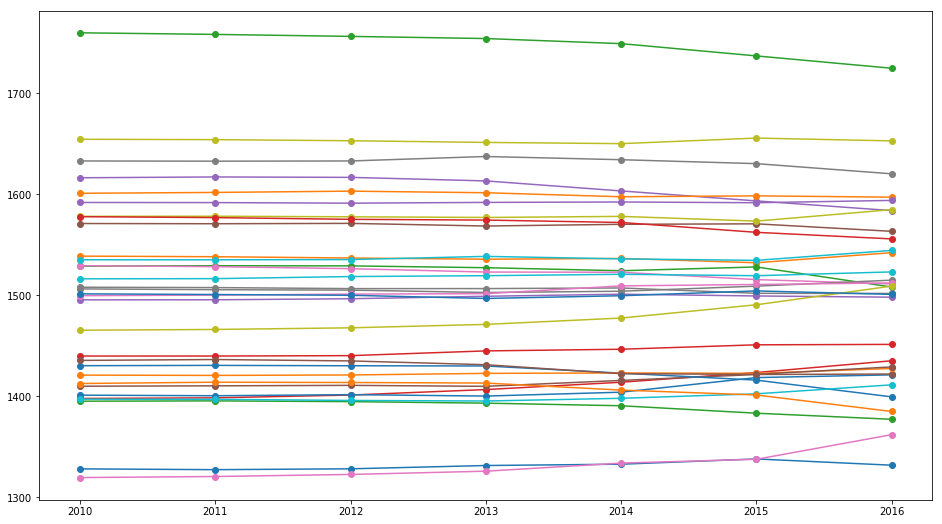

In [24]:
plt.figure(figsize=(16,9))
for team in active_teams:
    plt.plot(year_based_results['start_year'], 
                [r[team] for r in year_based_results['ratings']],
            marker='o')

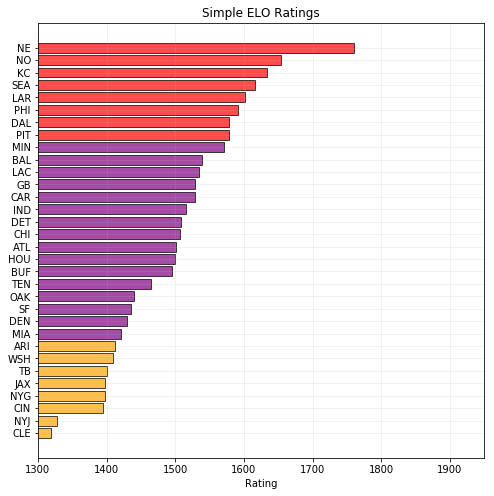

In [25]:
plot_ratings(year_based_results['ratings'][0])

In [26]:
def entropy_metric(pred, truth, epsilon=1e-9):
    ''' Calculate the cross-entropy for these predictions.  In this function, I assume that
    the prediction is a probability, and the truth information is the outcome of the game.  
    The outcome variable can be:
        0 - The team lost 
        1 - The team won 
        0.5 - The game was a draw 
    
    The formula applied for each prediction is: 
        cross_entropy (win) = ln(1 - prob)
        cross_entropy (lose) = ln(prob)
        
    '''
    pred = np.clip(pred, epsilon, 1 - epsilon)
    
    win_index = np.where(truth == 1)[0]
    loss_index = np.where(truth == 0)[0]    
    loss = np.zeros(len(truth))
    loss[win_index] = -1 * np.log(pred[win_index])
    loss[loss_index] = -1 * np.log(1-pred[loss_index])
    return np.mean(loss)

def get_game_outcome(game):
    ''' By default, return 0.5 for a draw.  Otherwise, return 1 if team1 won, otherwise return 0.'''
    if game['score1'] > game['score2']:
        return 1.0
    elif game['score1'] == game['score2']:
        return 0.5
    else:
        return 0.0
    
def get_entropy_metric_for_df(df):
    df['outcome'] = df.apply(get_game_outcome, axis=1)
    return entropy_metric(df['elo_prob1'].values, df['outcome'].values)

In [27]:
train_data = data[['team1', 'team2', 'score1', 'score2', 'season', 'date']] 

In [28]:
reward_values = range(1,75,2)
entropy_values = []

for reward in reward_values:
    print(f'Working on {reward}')
    d, r = simple_elo(train_data[train_data['season'] > 2000], active_teams, 1500, reward)
    entropy_values.append(
        get_entropy_metric_for_df(d[d['season'] == 2018])
    )

Working on 1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Working on 3
Working on 5
Working on 7
Working on 9
Working on 11
Working on 13
Working on 15
Working on 17
Working on 19
Working on 21
Working on 23
Working on 25
Working on 27
Working on 29
Working on 31
Working on 33
Working on 35
Working on 37
Working on 39
Working on 41
Working on 43
Working on 45
Working on 47
Working on 49
Working on 51
Working on 53
Working on 55
Working on 57
Working on 59
Working on 61
Working on 63
Working on 65
Working on 67
Working on 69
Working on 71
Working on 73


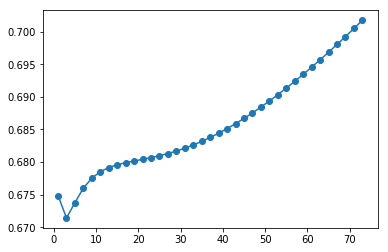

In [29]:
plt.plot(reward_values, entropy_values, marker='o')

In [30]:
start_values = range(1000,2000,50)
entropy_values = []

for sv in start_values:
    print(f'Working on {sv}')
    d, r = simple_elo(train_data[train_data['season'] > 2000], active_teams, sv, 25)
    entropy_values.append(
        get_entropy_metric_for_df(d[d['season'] == 2018])
    )

Working on 1000


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Working on 1050
Working on 1100
Working on 1150
Working on 1200
Working on 1250
Working on 1300
Working on 1350
Working on 1400
Working on 1450
Working on 1500
Working on 1550
Working on 1600
Working on 1650
Working on 1700
Working on 1750
Working on 1800
Working on 1850
Working on 1900
Working on 1950


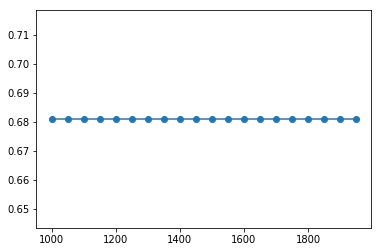

In [31]:
plt.plot(start_values, entropy_values, marker='o')

That's an important check.  It shouldn't matter what value you start at, because everyone changes over time up and down.

In [32]:
def elo2(train_data, active_teams, start_rating = 1250, 
         reward = 25, home_field_advantage = 25):

    ngames = len(train_data)

    # Setup the output fields 
    elo1_pre = np.repeat(start_rating, ngames)
    elo2_pre = np.repeat(start_rating, ngames)
    elo1_post = np.repeat(start_rating, ngames)
    elo2_post = np.repeat(start_rating, ngames)
    elo_prob1 = np.repeat(0.5, ngames)
    elo_prob2 = np.repeat(0.5, ngames)

    current_ratings = { team:start_rating for team in active_teams }

    for index in range(ngames):    

        # Get the current matchup between two teams 
        game = train_data.iloc[index]
        team1, team2 = game['team1'], game['team2']

        # Get thier current ratings from our dictionary 
        rating1, rating2 = current_ratings[team1], current_ratings[team2]    
        elo1_pre[index] = rating1
        elo2_pre[index] = rating2

        # Calculate the win probability for each team 
        prob1 = win_proba(rating1 + home_field_advantage, rating2)
        prob2 = 1.0 - prob1
        elo_prob1[index] = prob1
        elo_prob2[index] = prob2

        # Figure out if the home team won, lost, and drew the game 
        outcome = 0
        if game['score1'] > game['score2']:
            outcome = 1
        elif game['score1'] < game['score2']:
            outcome = -1

        # Update the ELO of each team based on the results 
        if outcome == 1:
            rating1 += reward * prob2
            rating2 -= reward * prob2
        elif outcome == -1:
            rating1 -= reward * prob1
            rating2 += reward * prob1

        # Update the dataframe and current ratings
        current_ratings[team1] = rating1
        current_ratings[team2] = rating2

        elo1_post[index] = rating1
        elo2_post[index] = rating2

    train_data['elo1_pre'] = elo1_pre
    train_data['elo2_pre'] = elo2_pre
    train_data['elo1_post'] = elo1_post
    train_data['elo2_post'] = elo2_post
    train_data['elo_prob1'] = elo_prob1
    train_data['elo_prob2'] = elo_prob2
    
    return train_data, current_ratings 

In [52]:
home_field_advantages = range(-50,100,5)
entropy_values = []

for hfa in home_field_advantages:
    print(f'Working on {hfa}')
    train_idx = train_data['season'] > 2000
    d, r = elo2(train_data[train_idx], active_teams, 1500, 25, hfa)
    entropy_values.append(
        get_entropy_metric_for_df(d[d['season'] > 2013])
    )

Working on -50


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Working on -45
Working on -40
Working on -35
Working on -30
Working on -25
Working on -20
Working on -15
Working on -10
Working on -5
Working on 0
Working on 5
Working on 10
Working on 15
Working on 20
Working on 25
Working on 30
Working on 35
Working on 40
Working on 45
Working on 50
Working on 55
Working on 60
Working on 65
Working on 70
Working on 75
Working on 80
Working on 85
Working on 90
Working on 95


Text(0, 0.5, 'Entropy')

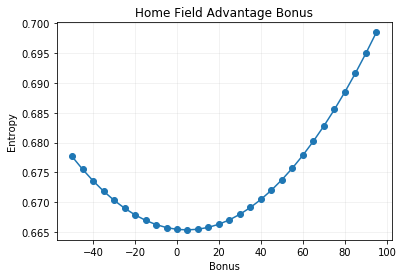

In [53]:
plt.plot(home_field_advantages, entropy_values, marker='o')
plt.grid(alpha=0.2)
plt.title('Home Field Advantage Bonus')
plt.xlabel('Bonus')
plt.ylabel('Entropy')

In [54]:
home_field_advantages[np.argmin(entropy_values)]

5

In [55]:
train_data['outcome'] = np.array(train_data['score1'] > train_data['score2']).astype(int)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
train_data['outcome'].value_counts()

1    7681
0    5946
Name: outcome, dtype: int64

In [57]:
rated_data, ratings = simple_elo(train_data[train_data['season'] > 2000], active_teams, 1500, 25)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

In [58]:
rated_data['diff'] = rated_data['elo2_pre'] - rated_data['elo1_pre'] 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'ELO Difference')

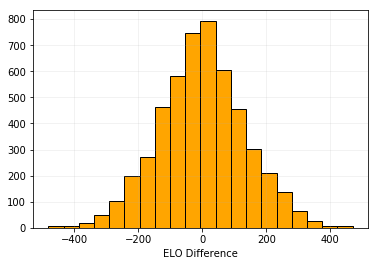

In [68]:
plt.hist(rated_data['diff'], edgecolor='k', color='orange', bins=20);
plt.grid(alpha=0.2)
plt.xlabel('ELO Difference')

In [60]:
time_ratings_spread = rated_data.groupby('season').aggregate({
    'diff' : [np.mean, np.std]
}).reset_index()
time_ratings_spread.columns = ['season', 'diff_mean', 'diff_std']

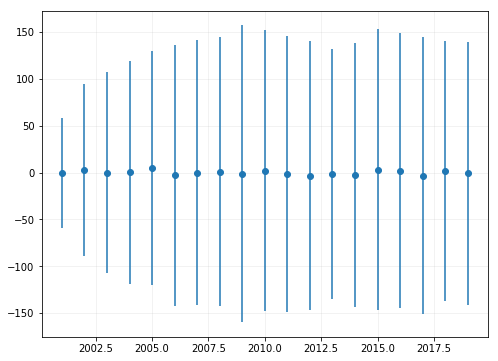

In [61]:
plt.figure(figsize=(8,6))
plt.errorbar(time_ratings_spread['season'], time_ratings_spread['diff_mean'],
            time_ratings_spread['diff_std'], marker='o', linestyle='')
plt.grid(alpha=0.2)

In [62]:
win_proba(35,0)

0.550199353253537

In [63]:
close_games = rated_data[np.logical_and(
    np.abs(rated_data['diff']) <= 35, rated_data['season'] > 2001)]

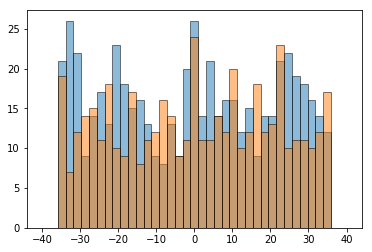

In [64]:
plt.hist(close_games[close_games['outcome'] == 1]['diff'], 
         edgecolor='k', alpha=0.5, bins=np.linspace(-40, 40, 40));
plt.hist(close_games[close_games['outcome'] == 0]['diff'], 
         edgecolor='k', alpha=0.5, bins=np.linspace(-40, 40, 40));

In [69]:
rated_data['diff'].describe()

count    5054.000000
mean       -0.147408
std       134.417173
min      -481.000000
25%       -88.000000
50%         0.000000
75%        85.000000
max       470.000000
Name: diff, dtype: float64

In [70]:
rated_data['diff_bin'] = np.digitize(rated_data['diff'], np.arange(-40,50,10))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [71]:
rated_data.groupby('diff_bin').aggregate({'outcome':'mean', 'diff':'mean'})

,outcome,diff
diff_bin,,
0,0.694312,-134.878256
1,0.543353,-35.283237
2,0.543353,-25.236994
3,0.565789,-15.513158
4,0.522059,-5.227941
5,0.564516,3.564516
6,0.483660,14.215686
7,0.576923,24.412088
8,0.493421,34.480263


In [123]:
final_data, final_ratings = elo2(train_data, active_teams, start_rating=1500, 
         reward=25, home_field_advantage=25)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

In [124]:
final_data

,team1,team2,score1,score2,season,date,outcome,elo1_pre,elo2_pre,elo1_post,elo2_post,elo_prob1,elo_prob2
2903,NE,DEN,10.0,13.0,1960,1960-09-09,0,1500,1500,1486,1513,0.535916,0.464084
2904,LAC,KC,21.0,20.0,1960,1960-09-10,1,1500,1500,1511,1488,0.535916,0.464084
2905,OAK,TEN,22.0,37.0,1960,1960-09-11,0,1500,1500,1486,1513,0.535916,0.464084
2906,NYJ,BUF,27.0,3.0,1960,1960-09-11,1,1500,1500,1511,1488,0.535916,0.464084
2907,OAK,KC,16.0,34.0,1960,1960-09-16,0,1486,1488,1473,1501,0.533344,0.466656
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16525,CAR,NO,NaN,NaN,2019,2019-12-29,0,1527,1651,1527,1651,0.360992,0.639008
16526,MIN,CHI,NaN,NaN,2019,2019-12-29,0,1569,1504,1569,1504,0.626603,0.373397
16527,SEA,SF,NaN,NaN,2019,2019-12-29,0,1612,1432,1612,1432,0.765424,0.234576
16528,DEN,OAK,NaN,NaN,2019,2019-12-29,0,1431,1439,1431,1439,0.524471,0.475529


In [125]:
final_ratings

{'NYJ': 1329.2057255244845,
 'BAL': 1541.2701437680653,
 'CAR': 1527.4295934021677,
 'JAX': 1402.785402176396,
 'SEA': 1612.5241266819742,
 'MIN': 1569.408583258065,
 'GB': 1527.9006433758798,
 'DET': 1505.1535294643156,
 'DAL': 1576.5553099973613,
 'IND': 1522.259402211263,
 'TB': 1398.9440908784118,
 'LAR': 1596.1815973849173,
 'NE': 1763.7637949635957,
 'PIT': 1579.3938997852708,
 'BUF': 1498.3414389744025,
 'WSH': 1408.4087440221492,
 'CLE': 1321.5809473318977,
 'CHI': 1504.480232823106,
 'NO': 1651.633183846111,
 'LAC': 1536.7520257275862,
 'DEN': 1431.7143942462992,
 'MIA': 1421.8564878858795,
 'CIN': 1397.841358261884,
 'OAK': 1439.69693835784,
 'PHI': 1592.0317820190317,
 'SF': 1432.0768103173796,
 'HOU': 1501.0454572957192,
 'KC': 1631.8297273256562,
 'TEN': 1470.006749684376,
 'NYG': 1395.7417850997003,
 'ATL': 1501.9776934539477,
 'ARI': 1410.2084004548653}

In [126]:
final_data[final_data['season'] > 2018]

,team1,team2,score1,score2,season,date,outcome,elo1_pre,elo2_pre,elo1_post,elo2_post,elo_prob1,elo_prob2
16274,CHI,GB,3.0,10.0,2019,2019-09-05,0,1495,1485,1481,1499,0.549659,0.450341
16275,JAX,KC,26.0,40.0,2019,2019-09-08,0,1395,1619,1389,1625,0.241254,0.758746
16276,CLE,TEN,13.0,43.0,2019,2019-09-08,0,1305,1489,1298,1496,0.286134,0.713866
16277,MIN,ATL,28.0,12.0,2019,2019-09-08,1,1573,1538,1583,1528,0.584477,0.415523
16278,NYJ,BUF,16.0,17.0,2019,2019-09-08,0,1360,1459,1350,1469,0.394221,0.605779
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16525,CAR,NO,NaN,NaN,2019,2019-12-29,0,1527,1651,1527,1651,0.360992,0.639008
16526,MIN,CHI,NaN,NaN,2019,2019-12-29,0,1569,1504,1569,1504,0.626603,0.373397
16527,SEA,SF,NaN,NaN,2019,2019-12-29,0,1612,1432,1612,1432,0.765424,0.234576
16528,DEN,OAK,NaN,NaN,2019,2019-12-29,0,1431,1439,1431,1439,0.524471,0.475529


In [127]:
from datetime import date

In [128]:
today = date.today()

In [129]:
print("Today's date:", today)

Today's date: 2019-10-12


In [130]:
final_data[final_data['date'] >= pd.Timestamp(today)]

,team1,team2,score1,score2,season,date,outcome,elo1_pre,elo2_pre,elo1_post,elo2_post,elo_prob1,elo_prob2
16353,TB,CAR,NaN,NaN,2019,2019-10-13,0,1398,1527,1398,1527,0.355326,0.644674
16354,MIA,WSH,NaN,NaN,2019,2019-10-13,0,1421,1408,1421,1408,0.555106,0.444894
16355,BAL,CIN,NaN,NaN,2019,2019-10-13,0,1541,1397,1541,1397,0.725031,0.274969
16356,KC,HOU,NaN,NaN,2019,2019-10-13,0,1631,1501,1631,1501,0.710285,0.289715
16357,CLE,SEA,NaN,NaN,2019,2019-10-13,0,1321,1612,1321,1612,0.177863,0.822137
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16525,CAR,NO,NaN,NaN,2019,2019-12-29,0,1527,1651,1527,1651,0.360992,0.639008
16526,MIN,CHI,NaN,NaN,2019,2019-12-29,0,1569,1504,1569,1504,0.626603,0.373397
16527,SEA,SF,NaN,NaN,2019,2019-12-29,0,1612,1432,1612,1432,0.765424,0.234576
16528,DEN,OAK,NaN,NaN,2019,2019-12-29,0,1431,1439,1431,1439,0.524471,0.475529


In [131]:
today = pd.Timestamp(today)

In [132]:
next_week = today + pd.Timedelta(1, unit='w')

In [133]:
weekly_preds = final_data[np.logical_and(final_data['date'] >= today, final_data['date'] < next_week)]

In [134]:
len(weekly_preds)

14

In [135]:
weekly_preds

,team1,team2,score1,score2,season,date,outcome,elo1_pre,elo2_pre,elo1_post,elo2_post,elo_prob1,elo_prob2
16353,TB,CAR,NaN,NaN,2019,2019-10-13,0,1398,1527,1398,1527,0.355326,0.644674
16354,MIA,WSH,NaN,NaN,2019,2019-10-13,0,1421,1408,1421,1408,0.555106,0.444894
16355,BAL,CIN,NaN,NaN,2019,2019-10-13,0,1541,1397,1541,1397,0.725031,0.274969
16356,KC,HOU,NaN,NaN,2019,2019-10-13,0,1631,1501,1631,1501,0.710285,0.289715
16357,CLE,SEA,NaN,NaN,2019,2019-10-13,0,1321,1612,1321,1612,0.177863,0.822137
16358,JAX,NO,NaN,NaN,2019,2019-10-13,0,1402,1651,1402,1651,0.216095,0.783905
16359,MIN,PHI,NaN,NaN,2019,2019-10-13,0,1569,1592,1569,1592,0.503420,0.496580
16360,LAR,SF,NaN,NaN,2019,2019-10-13,0,1596,1432,1596,1432,0.748113,0.251887
16361,ARI,ATL,NaN,NaN,2019,2019-10-13,0,1410,1501,1410,1501,0.405077,0.594923
16362,DEN,TEN,NaN,NaN,2019,2019-10-13,0,1431,1470,1431,1470,0.480880,0.519120


In [136]:
weekly_preds.iloc[0]

team1                         TB
team2                        CAR
score1                       NaN
score2                       NaN
season                      2019
date         2019-10-13 00:00:00
outcome                        0
elo1_pre                    1398
elo2_pre                    1527
elo1_post                   1398
elo2_post                   1527
elo_prob1               0.355326
elo_prob2               0.644674
Name: 16353, dtype: object

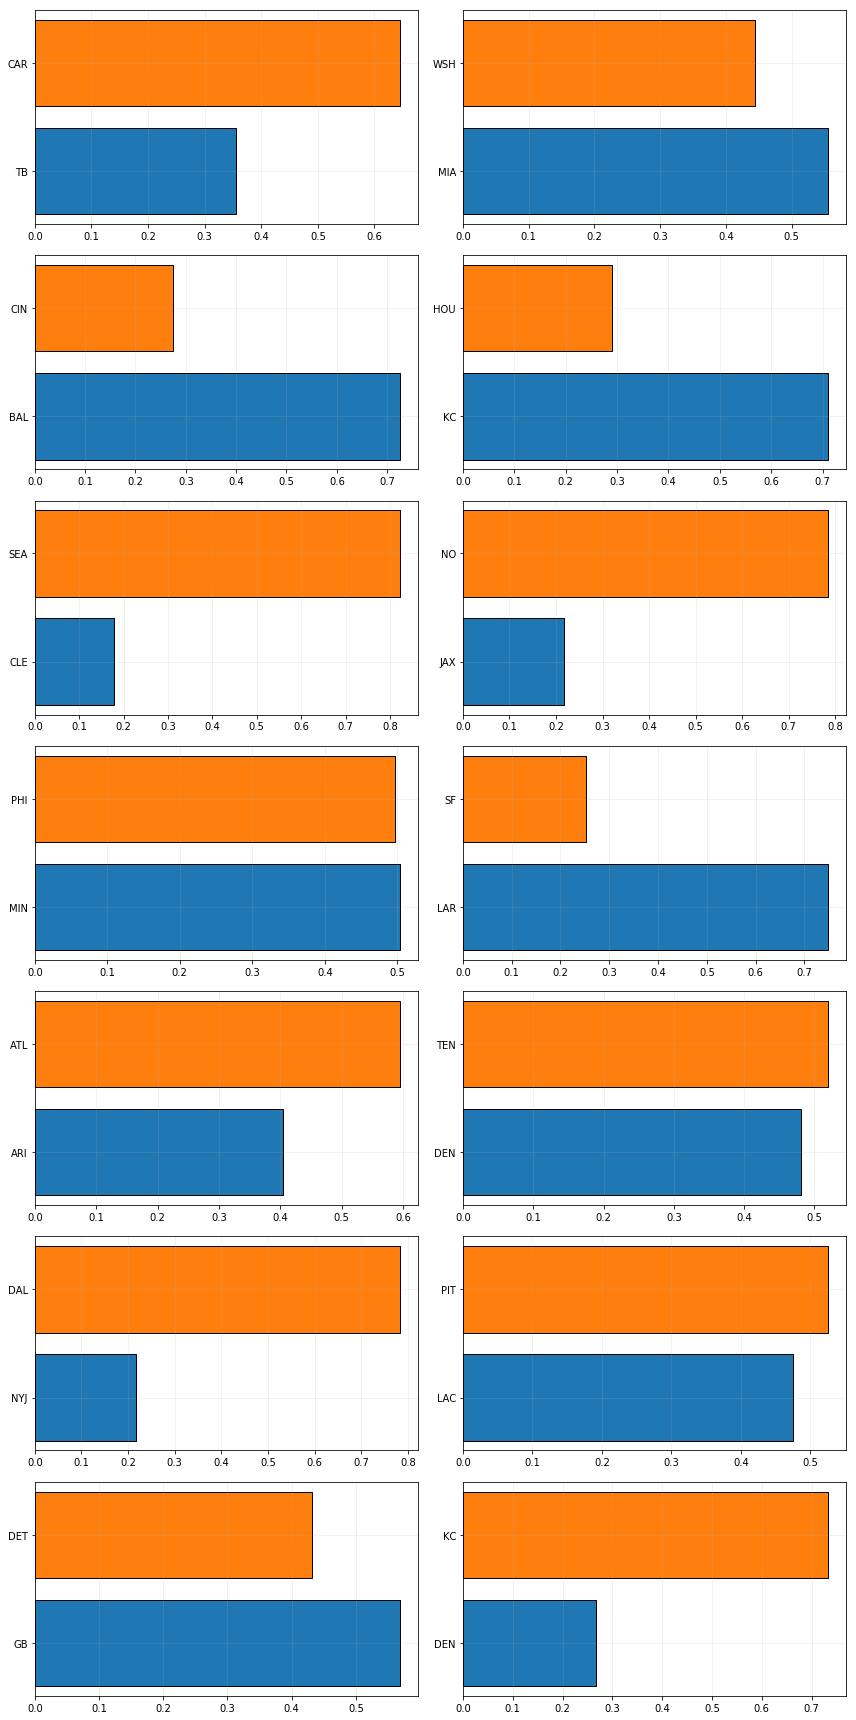

In [137]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12,24))

for irow in range(7):
    for icol in range(2):
        index = 2 * irow + icol
        axes[irow, icol].barh(weekly_preds.iloc[index]['team1'], 
                 weekly_preds.iloc[index]['elo_prob1'], edgecolor='k')
        axes[irow, icol].barh(weekly_preds.iloc[index]['team2'], 
                 weekly_preds.iloc[index]['elo_prob2'], edgecolor='k')
        axes[irow, icol].grid(alpha=0.2)
        
fig.tight_layout() 

In [221]:
def plot_game_pred(game):

    # set up the figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(0,10)
    ax.set_ylim(0,10)

    # draw lines
    xmin = 1
    xmax = 9
    y = 5
    height = 1.5

    plt.hlines(y, xmin, xmax, linewidth=1)
    plt.vlines(xmin, y - height / 2., y + height / 2., linewidth=1)
    plt.vlines(xmax, y - height / 2., y + height / 2., linewidth=1)

    nx = 4
    dx = (xmax-xmin) / nx
    for i in range(1,nx):
        plt.vlines(xmin + i*dx, y - height / 8., y + height / 8., linewidth=1)
    
    # draw a point on the line
    px = 1 + 8 * game['elo_prob2']
    plt.plot(px,y, 'o', ms = 10, mfc = 'orange', alpha=0.8)

    # add numbers
    title1 = '{} ({})'.format(game['team1'], game['elo1_pre'])
    title2 = '{} ({})'.format(game['team2'], game['elo2_pre'])
    plt.text(xmin - 0.2, y - 0.1, title1, horizontalalignment='right')
    plt.text(xmax + 0.2, y - 0.1, title2, horizontalalignment='left')
    
    proba = game['elo_prob1'] if game['elo_prob1'] > game['elo_prob2'] else game['elo_prob2'] 
    plt.text(px - 0.3, y - 1.1, '{0:2d}%'.format(int(100 * proba)))
    
    plt.axis('off')
    plt.show()

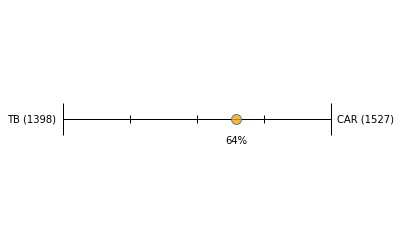

In [222]:
plot_game_pred(weekly_preds.iloc[0])

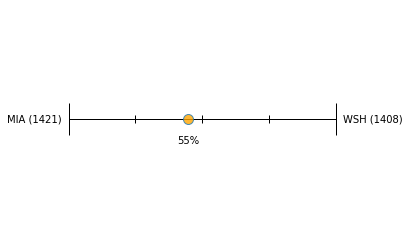

In [223]:
plot_game_pred(weekly_preds.iloc[1])

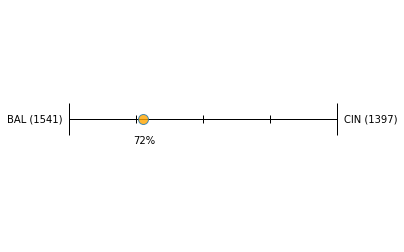

In [224]:
plot_game_pred(weekly_preds.iloc[2])

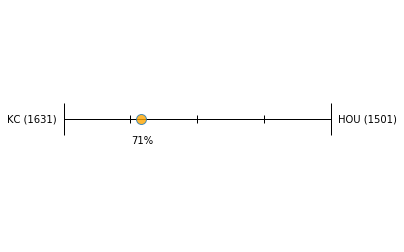

In [226]:
plot_game_pred(weekly_preds.iloc[3])

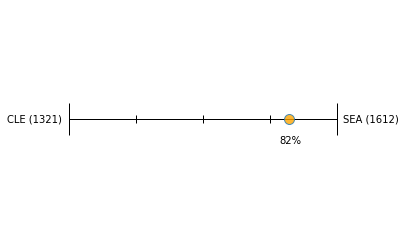

In [227]:
plot_game_pred(weekly_preds.iloc[4])

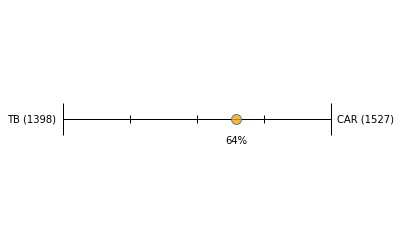

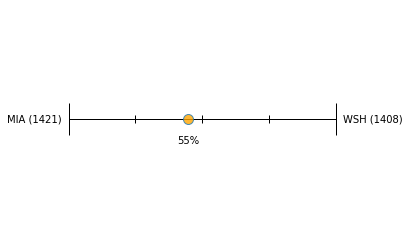

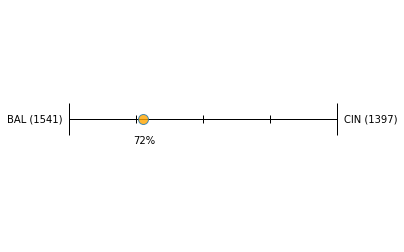

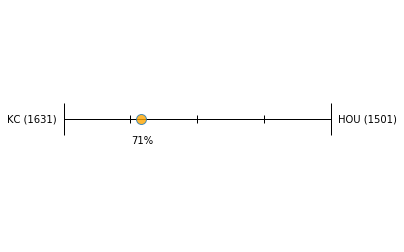

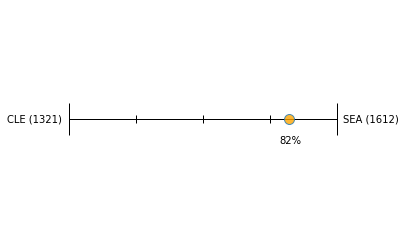

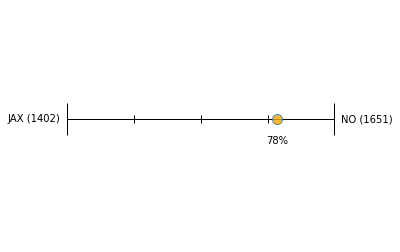

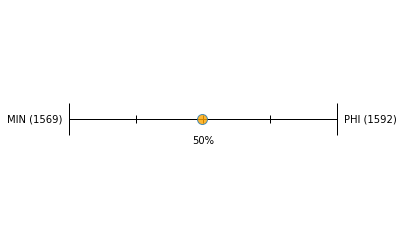

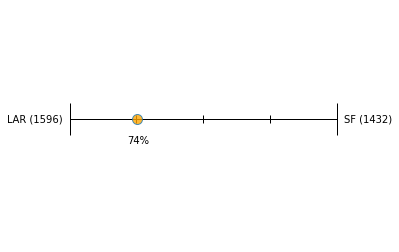

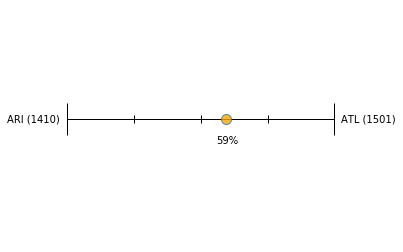

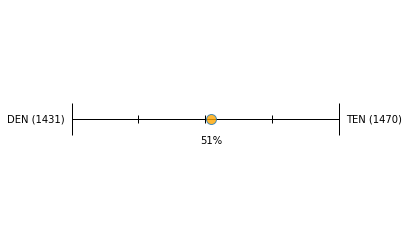

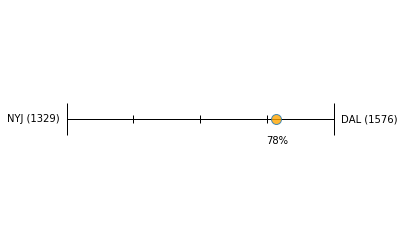

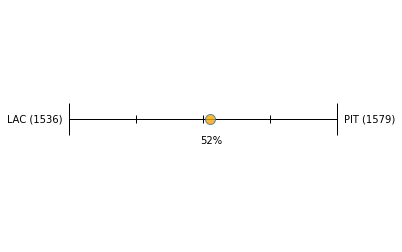

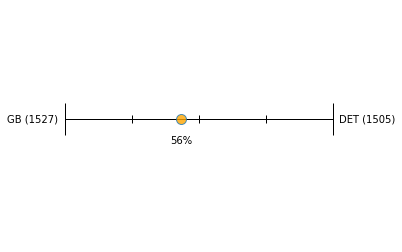

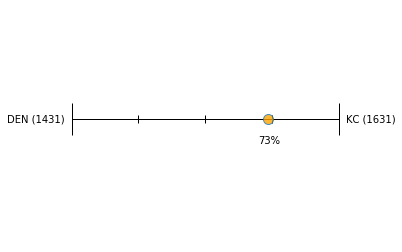

In [228]:
for i in range(14):
    plot_game_pred(weekly_preds.iloc[i])

In [229]:
last_week = today - pd.Timedelta(1, 'w')
last_week_results = final_data[np.logical_and(final_data['date'] <= today, final_data['date'] > last_week)]

In [230]:
last_week_results

,team1,team2,score1,score2,season,date,outcome,elo1_pre,elo2_pre,elo1_post,elo2_post,elo_prob1,elo_prob2
16338,NO,TB,31.0,24.0,2019,2019-10-06,1,1647,1403,1651,1398,0.824629,0.175371
16339,OAK,CHI,24.0,21.0,2019,2019-10-06,1,1424,1519,1439,1504,0.400970,0.599030
16340,HOU,ATL,53.0,32.0,2019,2019-10-06,1,1488,1514,1501,1501,0.498554,0.501446
16341,PHI,NYJ,31.0,6.0,2019,2019-10-06,1,1587,1333,1592,1329,0.833254,0.166746
16342,WSH,NE,7.0,33.0,2019,2019-10-06,0,1411,1757,1408,1761,0.136036,0.863964
16343,PIT,BAL,23.0,26.0,2019,2019-10-06,0,1595,1525,1579,1541,0.633113,0.366887
16344,NYG,MIN,10.0,28.0,2019,2019-10-06,0,1406,1561,1398,1569,0.320928,0.679072
16345,CAR,JAX,34.0,27.0,2019,2019-10-06,1,1519,1410,1527,1402,0.683597,0.316403
16346,TEN,BUF,7.0,14.0,2019,2019-10-06,0,1483,1485,1470,1498,0.533542,0.466458
16347,CIN,ARI,23.0,26.0,2019,2019-10-06,0,1411,1396,1397,1410,0.558074,0.441926


In [231]:
weekly_preds

,team1,team2,score1,score2,season,date,outcome,elo1_pre,elo2_pre,elo1_post,elo2_post,elo_prob1,elo_prob2
16353,TB,CAR,NaN,NaN,2019,2019-10-13,0,1398,1527,1398,1527,0.355326,0.644674
16354,MIA,WSH,NaN,NaN,2019,2019-10-13,0,1421,1408,1421,1408,0.555106,0.444894
16355,BAL,CIN,NaN,NaN,2019,2019-10-13,0,1541,1397,1541,1397,0.725031,0.274969
16356,KC,HOU,NaN,NaN,2019,2019-10-13,0,1631,1501,1631,1501,0.710285,0.289715
16357,CLE,SEA,NaN,NaN,2019,2019-10-13,0,1321,1612,1321,1612,0.177863,0.822137
16358,JAX,NO,NaN,NaN,2019,2019-10-13,0,1402,1651,1402,1651,0.216095,0.783905
16359,MIN,PHI,NaN,NaN,2019,2019-10-13,0,1569,1592,1569,1592,0.503420,0.496580
16360,LAR,SF,NaN,NaN,2019,2019-10-13,0,1596,1432,1596,1432,0.748113,0.251887
16361,ARI,ATL,NaN,NaN,2019,2019-10-13,0,1410,1501,1410,1501,0.405077,0.594923
16362,DEN,TEN,NaN,NaN,2019,2019-10-13,0,1431,1470,1431,1470,0.480880,0.519120
